# JSON Parsor
---

## 1. environment setting
---

### 1. import package

In [2]:
import json
import os
import glob
import folium
import csv
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

from shapely import wkt
from shapely import affinity
from tqdm.notebook import tqdm

### 2. set path

In [3]:
BASE_PATH = os.path.join(os.getenv('HOME'), 'workspace/Hackerton') # project folder
DATA_PATH = os.path.join(BASE_PATH, 'RSI_OP_NIA_AIHUB') # data folder
SAMPLE_GEOJSON_PATH = os.path.join(DATA_PATH, 'buildings/training/label/BLD00001_PS3_K3A_NIA0276.json') # sample geojson file path
MERGED_PATH = os.path.join(DATA_PATH, 'merged') # summary dir folder

BUILDINGS_TRAIN_LABEL_PATH = os.path.join(DATA_PATH, 'buildings/training/label')
BUILDINGS_VAL_LABEL_PATH = os.path.join(DATA_PATH, 'buildings/validation/label')
ROADS_TRAIN_LABEL_PATH = os.path.join(DATA_PATH, 'roads/training/label')
ROADS_VAL_LABEL_PATH = os.path.join(DATA_PATH, 'roads/validation/label')

In [3]:
SAMPLE_GEOJSON_PATH

'/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/label/BLD00001_PS3_K3A_NIA0276.json'

### 3. load json file

In [4]:
with open(SAMPLE_GEOJSON_PATH, "r") as st_json:
    st_python = json.load(st_json)

type(st_python)

dict

## 2. Parse Json to class
---

### 1. define class :: type1

![CD_geojson.png](./assets/CD_geojson.png)

In [5]:
class Property():
    def __init__(self, raw):
        self.object_imcoords = raw['object_imcoords'] if 'object_imcoords' in raw else "EMPTY"
        self.building_imcoords = raw['building_imcoords'] if 'building_imcoords' in raw else "EMPTY"
        self.road_imcoords = raw['road_imcoords'] if 'road_imcoords' in raw else "EMPTY"
        self.image_id = raw['image_id'] if 'image_id' in raw else None
        self.ingest_time = raw['ingest_time'] if 'ingest_time' in raw else None
        self.type_id = raw['type_id'] if 'type_id' in raw else None
        self.type_name = raw['type_name'] if 'type_name' in raw else None
        
    def is_building(self):
        ans = False
        if self.building_imcoords != "EMPTY" and self.road_imcoords == "EMPTY":
            ans = True
        return ans
    
    def is_road(self):
        ans = False
        if self.building_imcoords == "EMPTY" and self.road_imcoords != "EMPTY":
            ans = True
        return ans
    
    def __str__(self):
        return f'''{{
    object_imcoords : {self.object_imcoords},
    building_imcoords : {self.building_imcoords},
    road_imcoords : {self.road_imcoords},
    image_id : {self.image_id},
    ingest_time : {self.ingest_time},
    type_id : {self.type_id},
    type_name : {self.type_name}
}}
        '''
    
    def __repr__(self):
        data_type = "building" if self.is_building() else "road"
        _str = ""
        if data_type == "building":
            _str = f'Property : data type({data_type}), coordinates({self.building_imcoords})'
        else:
            _str = f'Property : data type({data_type}), coordinates({self.road_imcoords})'
        return _str

In [6]:
class Geometry():
    def __init__(self, raw):
        self.coordinates = raw['coordinates'] if 'coordinates' in raw else []
        self.type = raw['type'] if 'type' in raw else ""

    def __str__(self):
        return f'''{{
    type : {self.type},
    coordinates : {self.coordinates}
}}
        '''
    
    def __repr__(self):
        return f'Geometry : data type({self.type}), coordinates({self.coordinates})'

In [7]:
class Feature():
    def __init__(self, raw):
        self.type = "Feature"
        self.geometry = Geometry(raw['geometry']) if 'geometry' in raw else None
        self.properties = Property(raw['properties']) if 'properties' in raw else None

    def __str__(self):
        return 'Feature : Geometry({}), data type({})'.format(
            self.geometry.type,
            "building" if self.properties.is_building() else "road"
        )
    
    def __repr__(self):
        return self.__str__()

In [8]:
class FeatureCollection():
    def __init__(self, raw):
        self.type = "FeatureCollection"
        self.features = []
        
        if 'features' in raw and type(raw['features']) == list:
            self.features = [ Feature(feature) for feature in raw['features'] ]
    
    def __str__(self):
        return f'FeatureCollection with {len(self.features)} features'
    
    def __repr__(self):
        return self.__str__()

In [9]:
fc = FeatureCollection(st_python)

In [10]:
fc

FeatureCollection with 215 features

In [11]:
fc.features[0]

Feature : Geometry(Polygon), data type(building)

In [12]:
fc.features[0].geometry

Geometry : data type(Polygon), coordinates([[31.4347031225, 30.0413951468, 0.0], [31.4405428056, 30.0414645232, 0.0], [31.4404632046, 30.0465452603, 0.0], [31.4346232236, 30.0464758698, 0.0]])

In [13]:
fc.features[0].properties

Property : data type(building), coordinates(856.2952642894032,1000.8046984782792,828.0083112141339,1024,879.9702141458786,1023.8647145722488,878.740346620867,1015.2556418971668)

In [14]:
print(fc.features[0].properties)

{
    object_imcoords : EMPTY,
    building_imcoords : 856.2952642894032,1000.8046984782792,828.0083112141339,1024,879.9702141458786,1023.8647145722488,878.740346620867,1015.2556418971668,
    road_imcoords : EMPTY,
    image_id : BLD00001_PS3_K3A_NIA0276.png,
    ingest_time : 2020-10-27T02:04:23.355595Z,
    type_id : 2,
    type_name : 아파트
}
        


In [15]:
img = [feature.properties.image_id for feature in fc.features]
set(img)

{'BLD00001_PS3_K3A_NIA0276.png'}

### 2. define class :: type 2

![image](./assets/CD_object.png)

In [16]:
class Object():
    def __init__(self, raw):
        self.area_id = raw['image_id'] if 'image_id' in raw else None
        self.imcoords = raw['imcoords_pix'] if 'imcoords_pix' in raw else None
        self.image_id = raw['imcoords_geo'] if 'imcoords_geo' in raw else None
        self.type = raw['type'] if 'type' in raw else None

In [17]:
class Site():
    def __init__(self, coodinates, area_id):
        self.coodinates = coodinates
        self.image_id = image_id
    
    def __str__(self):
        return f'Site({self.image_id}) : {self.coordinates}'

### 3. parsing

#### A. load all json file

In [18]:
def load_json(file_paths):
    res = {}
    for file_path in tqdm(file_paths):
        with open(file_path, "r") as f:
            name = os.path.basename(f.name)
            if name in res:
                print(f'WARNING : file name {naem} is duplicated')
            else:
                res[name] = json.load(f)
    return res

In [19]:
buildings_train_label_pattern = BUILDINGS_TRAIN_LABEL_PATH + r"/*.json"
buildings_val_label_pattern = BUILDINGS_VAL_LABEL_PATH + r"/*.json"
roads_train_label_pattern = ROADS_TRAIN_LABEL_PATH + r"/*.json"
roads_val_label_pattern = ROADS_VAL_LABEL_PATH + r"/*.json"

In [20]:
buildings_train_label_paths = glob.glob(buildings_train_label_pattern)
buildings_val_label_paths = glob.glob(buildings_val_label_pattern)
roads_train_label_paths = glob.glob(roads_train_label_pattern)
roads_val_label_paths = glob.glob(roads_val_label_pattern)

print(f'len(buildings_train_label_paths) : {len(buildings_train_label_paths)}')
print(f'len(buildings_val_label_paths) : {len(buildings_val_label_paths)}')
print(f'len(roads_train_label_paths) : {len(roads_train_label_paths)}')
print(f'len(roads_val_label_paths) : {len(roads_val_label_paths)}')

len(buildings_train_label_paths) : 1238
len(buildings_val_label_paths) : 159
len(roads_train_label_paths) : 1143
len(roads_val_label_paths) : 127


In [21]:
buildings_train_label_json = load_json(buildings_train_label_paths)
buildings_val_label_json = load_json(buildings_val_label_paths)
roads_train_label_json = load_json(roads_train_label_paths)
roads_val_label_json = load_json(roads_val_label_paths)

  0%|          | 0/1238 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/1143 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

In [22]:
print(f'len(buildings_train_label_json) : {len(buildings_train_label_json)}')
print(f'len(buildings_val_label_json) : {len(buildings_val_label_json)}')
print(f'len(roads_train_label_json) : {len(roads_train_label_json)}')
print(f'len(roads_val_label_json) : {len(roads_val_label_json)}')

len(buildings_train_label_json) : 1238
len(buildings_val_label_json) : 159
len(roads_train_label_json) : 1143
len(roads_val_label_json) : 127


In [23]:
all_keys = list(buildings_train_label_json.keys()) + \
           list(buildings_val_label_json.keys()) + \
           list(roads_train_label_json.keys()) + \
           list(roads_val_label_json.keys())
print(len(all_keys), len(list(set(all_keys))))
### key들에 중복이 존재

2667 2208


#### B. parse json as class

In [24]:
all_json = list(buildings_train_label_json.values()) + \
           list(buildings_val_label_json.values()) +  \
           list(roads_train_label_json.values()) + \
           list(roads_val_label_json.values())
feature_collections = [ FeatureCollection(_json) for _json in tqdm(all_json) ]

  0%|          | 0/2667 [00:00<?, ?it/s]

In [25]:
feature_collections[0]

FeatureCollection with 82 features

In [26]:
feature_collections[0].features[0]

Feature : Geometry(Polygon), data type(building)

In [27]:
feature_collections[0].features[0].geometry

Geometry : data type(Polygon), coordinates([[-104.8997128936, 39.7169121313, 0.0], [-104.8913499349, 39.7169046065, 0.0], [-104.8913397997, 39.7233631342, 0.0], [-104.8997035385, 39.7233706607, 0.0]])

In [28]:
print(feature_collections[0].features[0].properties)

{
    object_imcoords : EMPTY,
    building_imcoords : -2.131628207280301e-14,148.53997916404757,1.0658141036401504e-14,91.30089230298044,36.04343457715326,66.05648613020645,42.82149838107574,74.12260545558313,48.909007119353994,70.06023460932046,76.68879915473228,107.60670945217178,55.94824243968657,122.33223161912196,42.204868036767515,104.95895503635784,17.85582895458094,122.653196720589,18.242827538633605,126.85505422323516,66.18095017953048,187.72328033711003,119.64492324076936,148.76699779173987,135.42422499984588,171.81463346302553,79.10903882572521,214.04945682270335,127.69867593135496,274.8882023996009,157.9430991782548,253.82912250916695,144.0530677611601,238.1468289737374,163.09585276846738,225.15292861581003,191.77204666182428,260.7741382177143,184.15493265890137,266.3749573375106,189.75575177869763,273.31997304605795,175.19362206722732,285.19370958002605,166.50123658597187,285.7097543174096,163.4767942612819,281.60747500129526,94.3177939773692,334.2568850694414,99.08721816

## 3. Abstract Area
---

- wkt
    - 정의 : https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry
    - 데이터 확인 : https://clydedacruz.github.io/openstreetmap-wkt-playground/

### 1. Geometry 추출

In [29]:
geometreis = [ [f.properties.image_id.split('.')[0], f.geometry] for fc in feature_collections for f in fc.features ]
len(geometreis), geometreis[0][0], geometreis[0][1].coordinates

(197931,
 'OBJ00875_PS3_K3_NIA0089',
 [[-104.8997128936, 39.7169121313, 0.0],
  [-104.8913499349, 39.7169046065, 0.0],
  [-104.8913397997, 39.7233631342, 0.0],
  [-104.8997035385, 39.7233706607, 0.0]])

### 2. list 형태로 되어 있는 좌표정보(coordinates)를 wkt로 변화

In [30]:
def coor_to_polygon(coordinates):
    """
    [[x1, y1, z1],
     [x2, y2, z2],
     [x3, y3, z3],
     [x4, y4, z4]]
    to
    POLYGON ((x1 y1, x2 y2, x3 y3, x4 y4, x1 y1))
    """
    coordinates.append(coordinates[0])
    wkt = "POLYGON(("
    wkt += ", ".join([" ".join(map(str, coor[:-1])) for coor in coordinates])
    wkt += "))"
    return wkt

In [31]:
areas = [(image_id, coor_to_polygon(geometry.coordinates)) for image_id, geometry in tqdm(geometreis)]
areas = list(set(areas))
print(len(areas), areas[0])

  0%|          | 0/197931 [00:00<?, ?it/s]

2208 ('BLD00330_PS3_K3A_NIA0276', 'POLYGON((31.4475696302 29.9653218787, 31.4534048961 29.9653905268, 31.4533261928 29.9704713537, 31.4474906303 29.9704026916, 31.4475696302 29.9653218787))')


### 3. csv 저장

In [32]:
def save_csv(path, data, fields):
    if type(data) != list:
        assert f'[save_csv] The type of input parameter data must be list.'
    if not data:
        assert f'[save_csv] The parameter data should not empty.'
    if len(data[0]) != len(fields):
        assert f'[save_csv] The number of data column and fields must be same.'
            
    with open(path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(fields)
        writer.writerows(data)

In [33]:
MERGED_PATH = os.path.join(DATA_PATH, 'merged')
save_csv(os.path.join(MERGED_PATH, 'Site.csv'), areas, ['image_id', 'coordinates'])

### 4. 저장된 파일 확인

In [34]:
area_path = os.path.join(MERGED_PATH, 'Site.csv')
df = pd.read_csv(area_path, encoding='utf-8')
df.head(5)

image_id                                        coordinates
0  BLD00330_PS3_K3A_NIA0276  POLYGON((31.4475696302 29.9653218787, 31.45340...
1  BLD07309_PS3_K3A_NIA0382  POLYGON((-117.981773523 33.832450748, -117.975...
2  BLD01440_PS3_K3A_NIA0373  POLYGON((121.5341833887 31.2528458309, 121.540...
3  BLD00133_PS3_K3A_NIA0276  POLYGON((31.3244367667 29.9993840638, 31.33027...
4  BLD04770_PS3_K3A_NIA0378  POLYGON((-118.3157353971 33.8387527249, -118.3...

In [35]:
df['coordinates'][0]

'POLYGON((31.4475696302 29.9653218787, 31.4534048961 29.9653905268, 31.4533261928 29.9704713537, 31.4474906303 29.9704026916, 31.4475696302 29.9653218787))'

In [36]:
df.describe(include='all')

image_id  \
count                      2208   
unique                     2208   
top     OBJ02100_PS3_K3_NIA0112   
freq                          1   

                                              coordinates  
count                                                2208  
unique                                               2208  
top     POLYGON((-118.3960864174 33.9140537083, -118.3...  
freq                                                    1

In [37]:
df['coordinates'] = gpd.GeoSeries.from_wkt(df['coordinates'])
gdf = gpd.GeoDataFrame(df, geometry='coordinates')
gdf.head(5)

image_id                                        coordinates
0  BLD00330_PS3_K3A_NIA0276  POLYGON ((31.44757 29.96532, 31.45340 29.96539...
1  BLD07309_PS3_K3A_NIA0382  POLYGON ((-117.98177 33.83245, -117.97569 33.8...
2  BLD01440_PS3_K3A_NIA0373  POLYGON ((121.53418 31.25285, 121.54010 31.252...
3  BLD00133_PS3_K3A_NIA0276  POLYGON ((31.32444 29.99938, 31.33027 29.99946...
4  BLD04770_PS3_K3A_NIA0378  POLYGON ((-118.31574 33.83875, -118.30965 33.8...

In [38]:
list(df['coordinates'][0].exterior.coords)

[(31.4475696302, 29.9653218787),
 (31.4534048961, 29.9653905268),
 (31.4533261928, 29.9704713537),
 (31.4474906303, 29.9704026916),
 (31.4475696302, 29.9653218787)]

In [39]:
type(gdf['coordinates'][0])

shapely.geometry.polygon.Polygon

#### A. **AREA 분포 확인**

In [40]:
m = folium.Map(zoom_start=8, tiles='CartoDB positron')

for _, r in gdf.iterrows():
    sim_geo = gpd.GeoSeries(r['coordinates']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['image_id']).add_to(geo_j)
    geo_j.add_to(m)
m

## 4. Abstract Building Object
---

### 1. Buildings 추출

In [41]:
def imcoords_to_wkt(coordinates):
    if coordinates == "":
        return None # Nan
    
    coor = coordinates.split(',')
    if len(coor) < 6:
        return None # 다각형은 세개 이상의 점으로 이루어 진다.
    
    
    coor = [f'{round(float(coor[i]))} {round(float(coor[i+1]))}' for i in range(0, len(coor), 2)]
    coor += [coor[0]]
    wkt = 'POLYGON((' + ", ".join(coor) + '))'
    return wkt

In [42]:
def get_building_attributes(feature):
    return {
        'image_id': feature.properties.image_id.split('.')[0],
        'type': "building",
        'coordinates_pix': imcoords_to_wkt(feature.properties.building_imcoords),
        'coordinates_geo': ""
    }

In [43]:
buildings = [get_building_attributes(f) for fc in feature_collections 
             for f in fc.features 
             if f.properties.is_building()]
buildings = [b for b in buildings if b['coordinates_pix']]
print(len(buildings))

172202


### 2. add site
- coordinates_geo 계산을 위하여 site의 좌표 정보를 불러온다.

In [44]:
site_df = pd.read_csv(area_path, encoding='utf-8')
site_df.head(5)

image_id                                        coordinates
0  BLD00330_PS3_K3A_NIA0276  POLYGON((31.4475696302 29.9653218787, 31.45340...
1  BLD07309_PS3_K3A_NIA0382  POLYGON((-117.981773523 33.832450748, -117.975...
2  BLD01440_PS3_K3A_NIA0373  POLYGON((121.5341833887 31.2528458309, 121.540...
3  BLD00133_PS3_K3A_NIA0276  POLYGON((31.3244367667 29.9993840638, 31.33027...
4  BLD04770_PS3_K3A_NIA0378  POLYGON((-118.3157353971 33.8387527249, -118.3...

In [45]:
building_df = pd.DataFrame(buildings)
building_df.head(5)

image_id      type  \
0  OBJ00875_PS3_K3_NIA0089  building   
1  OBJ00875_PS3_K3_NIA0089  building   
2  OBJ00875_PS3_K3_NIA0089  building   
3  OBJ00875_PS3_K3_NIA0089  building   
4  OBJ00875_PS3_K3_NIA0089  building   

                                     coordinates_pix coordinates_geo  
0  POLYGON((0 149, 0 91, 36 66, 43 74, 49 70, 77 ...                  
1  POLYGON((126 110, 176 176, 203 155, 159 95, 14...                  
2  POLYGON((117 72, 137 98, 182 66, 162 39, 117 72))                  
3  POLYGON((185 6, 257 105, 286 83, 222 0, 191 0,...                  
4  POLYGON((189 179, 207 203, 253 169, 235 145, 1...

In [46]:
merged = pd.merge(building_df, site_df, left_on="image_id", right_on="image_id", how="inner")
merged.head(5)

image_id      type  \
0  OBJ00875_PS3_K3_NIA0089  building   
1  OBJ00875_PS3_K3_NIA0089  building   
2  OBJ00875_PS3_K3_NIA0089  building   
3  OBJ00875_PS3_K3_NIA0089  building   
4  OBJ00875_PS3_K3_NIA0089  building   

                                     coordinates_pix coordinates_geo  \
0  POLYGON((0 149, 0 91, 36 66, 43 74, 49 70, 77 ...                   
1  POLYGON((126 110, 176 176, 203 155, 159 95, 14...                   
2  POLYGON((117 72, 137 98, 182 66, 162 39, 117 72))                   
3  POLYGON((185 6, 257 105, 286 83, 222 0, 191 0,...                   
4  POLYGON((189 179, 207 203, 253 169, 235 145, 1...                   

                                         coordinates  
0  POLYGON((-104.8997128936 39.7169121313, -104.8...  
1  POLYGON((-104.8997128936 39.7169121313, -104.8...  
2  POLYGON((-104.8997128936 39.7169121313, -104.8...  
3  POLYGON((-104.8997128936 39.7169121313, -104.8...  
4  POLYGON((-104.8997128936 39.7169121313, -104.8...

In [47]:
len(building_df), len(merged)

(172202, 172202)

In [48]:
merged['coordinates'] = gpd.GeoSeries.from_wkt(merged['coordinates'])
merged['coordinates_pix'] = gpd.GeoSeries.from_wkt(merged['coordinates_pix'])
merged_gdf = gpd.GeoDataFrame(merged, geometry='coordinates_pix')
merged_gdf.head(5)

image_id      type  \
0  OBJ00875_PS3_K3_NIA0089  building   
1  OBJ00875_PS3_K3_NIA0089  building   
2  OBJ00875_PS3_K3_NIA0089  building   
3  OBJ00875_PS3_K3_NIA0089  building   
4  OBJ00875_PS3_K3_NIA0089  building   

                                     coordinates_pix coordinates_geo  \
0  POLYGON ((0.000 149.000, 0.000 91.000, 36.000 ...                   
1  POLYGON ((126.000 110.000, 176.000 176.000, 20...                   
2  POLYGON ((117.000 72.000, 137.000 98.000, 182....                   
3  POLYGON ((185.000 6.000, 257.000 105.000, 286....                   
4  POLYGON ((189.000 179.000, 207.000 203.000, 25...                   

                                         coordinates  
0  POLYGON ((-104.89971 39.71691, -104.89135 39.7...  
1  POLYGON ((-104.89971 39.71691, -104.89135 39.7...  
2  POLYGON ((-104.89971 39.71691, -104.89135 39.7...  
3  POLYGON ((-104.89971 39.71691, -104.89135 39.7...  
4  POLYGON ((-104.89971 39.71691, -104.89135 39.7...

### 3. coordinates_geo 계산

In [49]:
def pix_coor_to_real_coor(site_geo, src, pix_size):
    real_URC = (site_geo.bounds[2], site_geo.bounds[3])
    real_LLC = (site_geo.bounds[0], site_geo.bounds[1])

    pix_width = pix_size # 1024*1024 고정
    pix_height = pix_size

    width_scale = abs((real_URC[0] - real_LLC[0]) / pix_width)
    height_scale = abs((real_URC[1] - real_LLC[1]) / pix_height)

    width_trans = real_LLC[0]
    height_trans = real_LLC[1]
    
    mirrored = affinity.affine_transform(src, [1, 0, 0, -1, 0, pix_height ])
    return affinity.affine_transform(mirrored, [width_scale, 0, 0, height_scale, width_trans, height_trans ])

In [50]:
list(merged_gdf.loc[0]['coordinates'].exterior.coords)

[(-104.8997128936, 39.7169121313),
 (-104.8913499349, 39.7169046065),
 (-104.8913397997, 39.7233631342),
 (-104.8997035385, 39.7233706607),
 (-104.8997128936, 39.7169121313)]

In [51]:
merged_gdf['coordinates_geo'] = merged_gdf.apply(lambda x: pix_coor_to_real_coor(x.coordinates, x.coordinates_pix, 1024), axis='columns')
merged_gdf.head(5)

image_id      type  \
0  OBJ00875_PS3_K3_NIA0089  building   
1  OBJ00875_PS3_K3_NIA0089  building   
2  OBJ00875_PS3_K3_NIA0089  building   
3  OBJ00875_PS3_K3_NIA0089  building   
4  OBJ00875_PS3_K3_NIA0089  building   

                                     coordinates_pix  \
0  POLYGON ((0.000 149.000, 0.000 91.000, 36.000 ...   
1  POLYGON ((126.000 110.000, 176.000 176.000, 20...   
2  POLYGON ((117.000 72.000, 137.000 98.000, 182....   
3  POLYGON ((185.000 6.000, 257.000 105.000, 286....   
4  POLYGON ((189.000 179.000, 207.000 203.000, 25...   

                                     coordinates_geo  \
0  POLYGON ((-104.8997128936 39.72242979929785, -...   
1  POLYGON ((-104.8986826105615 39.72267606503399...   
2  POLYGON ((-104.8987562022071 39.72291601626406...   
3  POLYGON ((-104.8982001764403 39.72333277366367...   
4  POLYGON ((-104.8981674690423 39.72224036411621...   

                                         coordinates  
0  POLYGON ((-104.89971 39.71691, -104.89135 39.7...  
1  POLYGON ((-104.89971 39.71691, -104.89135 39.7...  
2  POLYGON ((-104.89971 39.71691, -104.89135 39.7...  
3  POLYGON ((-104.89971 39.71691, -104.89135 39.7...  
4  POLYGON ((-104.89971 39.71691, -104.89135 39.7...

#### A. 계산된 데이터 확인 1 - matplot

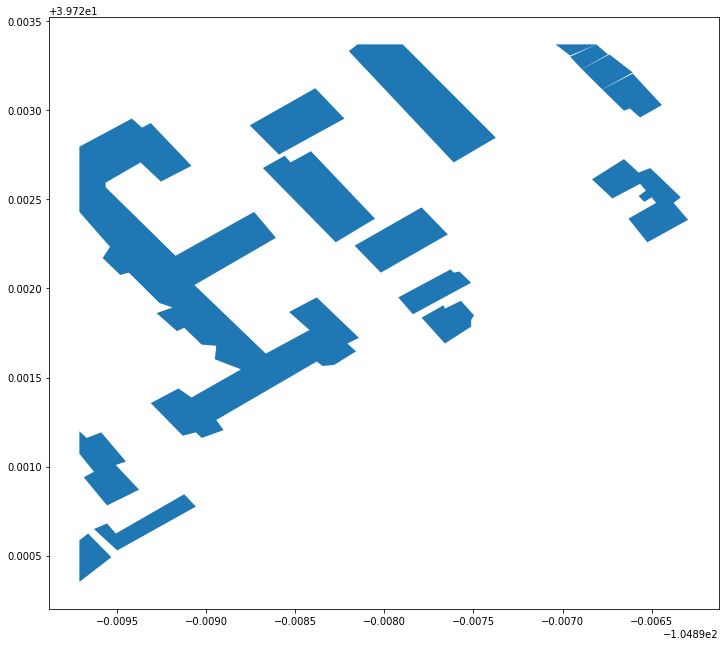

In [52]:
tmp = gpd.GeoSeries(merged_gdf[:15]['coordinates_geo'])
tmp.plot(figsize=(12,12))
plt.show()

#### B. 계산된 데이터 확인 2 - folium

In [53]:
m = folium.Map(zoom_start=17, location=[39.7213631342, -104.8953397997], tiles='CartoDB positron')

for i, r in merged_gdf[:50].iterrows():    
    sim_geo = gpd.GeoSeries(r['coordinates_geo']).simplify(tolerance=0.00001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(f'idx({i})').add_to(geo_j)
    geo_j.add_to(m)
m

### 4. csv 저장

In [54]:
merged_gdf.drop('coordinates', axis=1).to_csv(os.path.join(MERGED_PATH, 'Buildings.csv'),',', index=False)

### 5. 저장된 파일 확인

In [55]:
area_path = os.path.join(MERGED_PATH, 'Buildings.csv')
df = pd.read_csv(area_path, encoding='utf-8')
df.head(5)

image_id      type  \
0  OBJ00875_PS3_K3_NIA0089  building   
1  OBJ00875_PS3_K3_NIA0089  building   
2  OBJ00875_PS3_K3_NIA0089  building   
3  OBJ00875_PS3_K3_NIA0089  building   
4  OBJ00875_PS3_K3_NIA0089  building   

                                     coordinates_pix  \
0  POLYGON ((0 149, 0 91, 36 66, 43 74, 49 70, 77...   
1  POLYGON ((126 110, 176 176, 203 155, 159 95, 1...   
2  POLYGON ((117 72, 137 98, 182 66, 162 39, 117 ...   
3  POLYGON ((185 6, 257 105, 286 83, 222 0, 191 0...   
4  POLYGON ((189 179, 207 203, 253 169, 235 145, ...   

                                     coordinates_geo  
0  POLYGON ((-104.8997128936 39.72242979929785, -...  
1  POLYGON ((-104.8986826105615 39.72267606503399...  
2  POLYGON ((-104.8987562022071 39.72291601626406...  
3  POLYGON ((-104.8982001764403 39.72333277366367...  
4  POLYGON ((-104.8981674690423 39.72224036411621...

In [56]:
df['coordinates_pix'] = gpd.GeoSeries.from_wkt(df['coordinates_pix'])
df['coordinates_geo'] = gpd.GeoSeries.from_wkt(df['coordinates_geo'])
gdf = gpd.GeoDataFrame(df, geometry='coordinates_pix')
gdf.tail(5)

image_id      type  \
172197  BLD01232_PS3_K3A_NIA0373  building   
172198  BLD01232_PS3_K3A_NIA0373  building   
172199  BLD01232_PS3_K3A_NIA0373  building   
172200  BLD01232_PS3_K3A_NIA0373  building   
172201  BLD01232_PS3_K3A_NIA0373  building   

                                          coordinates_pix  \
172197  POLYGON ((607.000 282.000, 606.000 366.000, 68...   
172198  POLYGON ((600.000 367.000, 599.000 483.000, 67...   
172199  POLYGON ((656.000 900.000, 642.000 900.000, 63...   
172200  POLYGON ((656.000 934.000, 646.000 934.000, 62...   
172201  POLYGON ((87.000 0.000, 74.000 12.000, 62.000 ...   

                                          coordinates_geo  
172197  POLYGON ((121.61394 31.29807, 121.61393 31.297...  
172198  POLYGON ((121.61390 31.29764, 121.61389 31.297...  
172199  POLYGON ((121.61422 31.29496, 121.61414 31.294...  
172200  POLYGON ((121.61422 31.29479, 121.61417 31.294...  
172201  POLYGON ((121.61090 31.29948, 121.61082 31.299...

## 5. Abstract Road Object
---

### 1. Road 추출

In [57]:
def get_road_attributes(feature):
    return {
        'image_id': feature.properties.image_id.split('.')[0],
        'type': "road",
        'coordinates_pix': imcoords_to_wkt(feature.properties.road_imcoords),
        'coordinates_geo': ""
    }

In [58]:
roads = [get_road_attributes(f) for fc in feature_collections 
             for f in fc.features 
             if f.properties.is_road()]
roads = [r for r in roads if r['coordinates_pix']]
print(len(roads))

25651


### 2. add site

In [59]:
area_path = os.path.join(MERGED_PATH, 'Site.csv')
site_df = pd.read_csv(area_path, encoding='utf-8')
site_df.head(5)

image_id                                        coordinates
0  BLD00330_PS3_K3A_NIA0276  POLYGON((31.4475696302 29.9653218787, 31.45340...
1  BLD07309_PS3_K3A_NIA0382  POLYGON((-117.981773523 33.832450748, -117.975...
2  BLD01440_PS3_K3A_NIA0373  POLYGON((121.5341833887 31.2528458309, 121.540...
3  BLD00133_PS3_K3A_NIA0276  POLYGON((31.3244367667 29.9993840638, 31.33027...
4  BLD04770_PS3_K3A_NIA0378  POLYGON((-118.3157353971 33.8387527249, -118.3...

In [60]:
road_df = pd.DataFrame(roads)
road_df.head(5)

image_id  type  \
0  BLD00586_PS3_K3A_NIA0277  road   
1  BLD00586_PS3_K3A_NIA0277  road   
2  BLD00586_PS3_K3A_NIA0277  road   
3  BLD00586_PS3_K3A_NIA0277  road   
4  BLD00586_PS3_K3A_NIA0277  road   

                                     coordinates_pix coordinates_geo  
0       POLYGON((0 419, 507 0, 532 0, 1 437, 0 419))                  
1       POLYGON((0 446, 542 0, 560 0, 0 466, 0 446))                  
2  POLYGON((0 390, 305 141, 475 0, 494 0, 169 270...                  
3  POLYGON((0 485, 61 431, 583 0, 573 1, 0 475, 0...                  
4  POLYGON((0 159, 70 194, 176 245, 170 251, 66 2...

In [61]:
merged = pd.merge(road_df, site_df, left_on="image_id", right_on="image_id", how="inner")
merged.head(5)

image_id  type  \
0  BLD00586_PS3_K3A_NIA0277  road   
1  BLD00586_PS3_K3A_NIA0277  road   
2  BLD00586_PS3_K3A_NIA0277  road   
3  BLD00586_PS3_K3A_NIA0277  road   
4  BLD00586_PS3_K3A_NIA0277  road   

                                     coordinates_pix coordinates_geo  \
0       POLYGON((0 419, 507 0, 532 0, 1 437, 0 419))                   
1       POLYGON((0 446, 542 0, 560 0, 0 466, 0 446))                   
2  POLYGON((0 390, 305 141, 475 0, 494 0, 169 270...                   
3  POLYGON((0 485, 61 431, 583 0, 573 1, 0 475, 0...                   
4  POLYGON((0 159, 70 194, 176 245, 170 251, 66 2...                   

                                         coordinates  
0  POLYGON((31.3900910242 30.145814825, 31.395936...  
1  POLYGON((31.3900910242 30.145814825, 31.395936...  
2  POLYGON((31.3900910242 30.145814825, 31.395936...  
3  POLYGON((31.3900910242 30.145814825, 31.395936...  
4  POLYGON((31.3900910242 30.145814825, 31.395936...

In [62]:
len(road_df), len(merged)

(25651, 25651)

In [63]:
merged['coordinates'] = gpd.GeoSeries.from_wkt(merged['coordinates'])
merged['coordinates_pix'] = gpd.GeoSeries.from_wkt(merged['coordinates_pix'])
merged_gdf = gpd.GeoDataFrame(merged, geometry='coordinates_pix')
merged_gdf.head(5)

image_id  type  \
0  BLD00586_PS3_K3A_NIA0277  road   
1  BLD00586_PS3_K3A_NIA0277  road   
2  BLD00586_PS3_K3A_NIA0277  road   
3  BLD00586_PS3_K3A_NIA0277  road   
4  BLD00586_PS3_K3A_NIA0277  road   

                                     coordinates_pix coordinates_geo  \
0  POLYGON ((0.000 419.000, 507.000 0.000, 532.00...                   
1  POLYGON ((0.000 446.000, 542.000 0.000, 560.00...                   
2  POLYGON ((0.000 390.000, 305.000 141.000, 475....                   
3  POLYGON ((0.000 485.000, 61.000 431.000, 583.0...                   
4  POLYGON ((0.000 159.000, 70.000 194.000, 176.0...                   

                                         coordinates  
0  POLYGON ((31.39009 30.14581, 31.39594 30.14589...  
1  POLYGON ((31.39009 30.14581, 31.39594 30.14589...  
2  POLYGON ((31.39009 30.14581, 31.39594 30.14589...  
3  POLYGON ((31.39009 30.14581, 31.39594 30.14589...  
4  POLYGON ((31.39009 30.14581, 31.39594 30.14589...

### 3. coordinates_geo 계산

In [64]:
merged_gdf['coordinates_geo'] = merged_gdf.apply(lambda x: pix_coor_to_real_coor(x.coordinates, x.coordinates_pix, 1024), axis='columns')
merged_gdf.head(5)

image_id  type  \
0  BLD00586_PS3_K3A_NIA0277  road   
1  BLD00586_PS3_K3A_NIA0277  road   
2  BLD00586_PS3_K3A_NIA0277  road   
3  BLD00586_PS3_K3A_NIA0277  road   
4  BLD00586_PS3_K3A_NIA0277  road   

                                     coordinates_pix  \
0  POLYGON ((0.000 419.000, 507.000 0.000, 532.00...   
1  POLYGON ((0.000 446.000, 542.000 0.000, 560.00...   
2  POLYGON ((0.000 390.000, 305.000 141.000, 475....   
3  POLYGON ((0.000 485.000, 61.000 431.000, 583.0...   
4  POLYGON ((0.000 159.000, 70.000 194.000, 176.0...   

                                     coordinates_geo  \
0  POLYGON ((31.3900085033 30.14885880628418, 31....   
1  POLYGON ((31.3900085033 30.14872295918555, 31....   
2  POLYGON ((31.3900085033 30.14900471613086, 31....   
3  POLYGON ((31.3900085033 30.14852673559863, 31....   
4  POLYGON ((31.3900085033 30.15016696353027, 31....   

                                         coordinates  
0  POLYGON ((31.39009 30.14581, 31.39594 30.14589...  
1  POLYGON ((31.39009 30.14581, 31.39594 30.14589...  
2  POLYGON ((31.39009 30.14581, 31.39594 30.14589...  
3  POLYGON ((31.39009 30.14581, 31.39594 30.14589...  
4  POLYGON ((31.39009 30.14581, 31.39594 30.14589...

#### A. 계산된 데이터 확인 1 - matplot

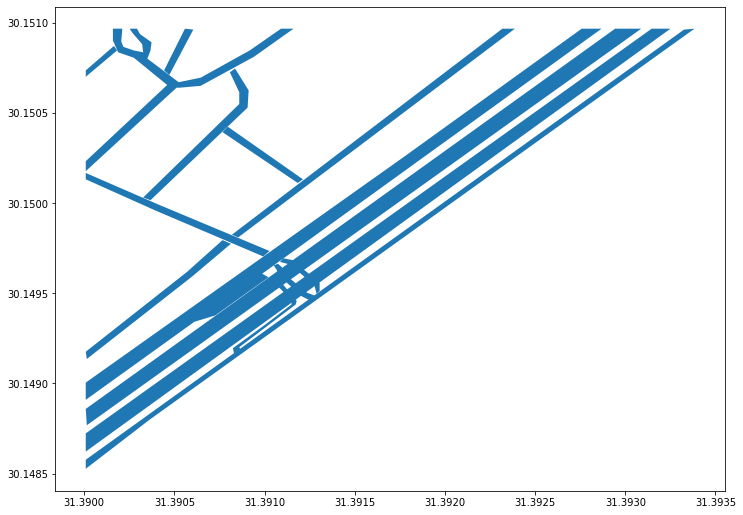

In [65]:
tmp = gpd.GeoSeries(merged_gdf[:15]['coordinates_geo'])
tmp.plot(figsize=(12,12))
plt.show()

#### B. 계산된 데이터 확인 2 - folium

In [66]:
m = folium.Map(zoom_start=17, location=[33.9516227282, -118.2718820291], tiles='cartodb positron')

for i, r in merged_gdf[:50].iterrows():    
    sim_geo = gpd.GeoSeries(r['coordinates_geo']).simplify(tolerance=0.00001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(f'idx({i})').add_to(geo_j)
    geo_j.add_to(m)
m

### 4. csv 저장

In [67]:
merged_gdf.drop('coordinates', axis=1).to_csv(os.path.join(MERGED_PATH, 'Roads.csv'),',', index=False)

### 5. 저장된 파일 확인

In [68]:
road_path = os.path.join(MERGED_PATH, 'Roads.csv')
df = pd.read_csv(road_path, encoding='utf-8')
df.head(5)

image_id  type  \
0  BLD00586_PS3_K3A_NIA0277  road   
1  BLD00586_PS3_K3A_NIA0277  road   
2  BLD00586_PS3_K3A_NIA0277  road   
3  BLD00586_PS3_K3A_NIA0277  road   
4  BLD00586_PS3_K3A_NIA0277  road   

                                     coordinates_pix  \
0      POLYGON ((0 419, 507 0, 532 0, 1 437, 0 419))   
1      POLYGON ((0 446, 542 0, 560 0, 0 466, 0 446))   
2  POLYGON ((0 390, 305 141, 475 0, 494 0, 169 27...   
3  POLYGON ((0 485, 61 431, 583 0, 573 1, 0 475, ...   
4  POLYGON ((0 159, 70 194, 176 245, 170 251, 66 ...   

                                     coordinates_geo  
0  POLYGON ((31.3900085033 30.14885880628418, 31....  
1  POLYGON ((31.3900085033 30.14872295918555, 31....  
2  POLYGON ((31.3900085033 30.14900471613086, 31....  
3  POLYGON ((31.3900085033 30.14852673559863, 31....  
4  POLYGON ((31.3900085033 30.15016696353027, 31....

In [69]:
df['coordinates_pix'] = gpd.GeoSeries.from_wkt(df['coordinates_pix'])
df['coordinates_geo'] = gpd.GeoSeries.from_wkt(df['coordinates_geo'])
gdf = gpd.GeoDataFrame(df, geometry='coordinates_pix')
gdf.tail(5)

image_id  type  \
25646  BLD00276_PS3_K3A_NIA0276  road   
25647  BLD01340_PS3_K3A_NIA0373  road   
25648  BLD01340_PS3_K3A_NIA0373  road   
25649  BLD01340_PS3_K3A_NIA0373  road   
25650  BLD01340_PS3_K3A_NIA0373  road   

                                         coordinates_pix  \
25646  POLYGON ((842.000 543.000, 858.000 553.000, 86...   
25647  POLYGON ((648.000 0.000, 635.000 212.000, 631....   
25648  POLYGON ((0.000 923.000, 70.000 977.000, 96.00...   
25649  POLYGON ((169.000 1024.000, 171.000 974.000, 1...   
25650  POLYGON ((217.000 0.000, 208.000 805.000, 203....   

                                         coordinates_geo  
25646  POLYGON ((31.42885 29.97763, 31.42895 29.97758...  
25647  POLYGON ((121.60264 31.27904, 121.60257 31.277...  
25648  POLYGON ((121.59885 31.27440, 121.59926 31.274...  
25649  POLYGON ((121.59984 31.27389, 121.59985 31.274...  
25650  POLYGON ((121.60012 31.27904, 121.60007 31.274...

## 6. Merge Building and Road summary
---

In [4]:
road_path = os.path.join(MERGED_PATH, 'Roads.csv')
building_path = os.path.join(MERGED_PATH, 'Buildings.csv')

df_road = pd.read_csv(road_path, encoding='utf-8')
df_building = pd.read_csv(building_path, encoding='utf-8')

In [12]:
merged = pd.concat([df_building, df_road], ignore_index=True).sort_values(by=['image_id']).reset_index(drop=True)
merged.head(5)

image_id      type  \
0  BLD00001_PS3_K3A_NIA0276  building   
1  BLD00001_PS3_K3A_NIA0276  building   
2  BLD00001_PS3_K3A_NIA0276  building   
3  BLD00001_PS3_K3A_NIA0276  building   
4  BLD00001_PS3_K3A_NIA0276  building   

                                     coordinates_pix  \
0  POLYGON ((245 508, 201 507, 202 540, 246 542, ...   
1  POLYGON ((108 349, 81 349, 82 402, 109 402, 10...   
2  POLYGON ((46 352, 73 353, 72 406, 45 404, 46 3...   
3    POLYGON ((8 351, 36 351, 36 404, 7 403, 8 351))   
4  POLYGON ((0 462, 9 457, 15 464, 16 508, 0 513,...   

                                     coordinates_geo  
0  POLYGON ((31.43603952984023 30.04399032118086,...  
1  POLYGON ((31.43524755451406 30.04478999700752,...  
2  POLYGON ((31.43488914232266 30.04477490878438,...  
3  POLYGON ((31.43466947033437 30.04477993819209,...  
4  POLYGON ((31.4346232236 30.04422167393574, 31....

In [13]:
merged.to_csv(os.path.join(MERGED_PATH, 'BnR.csv'),',', index=False)

In [14]:
merged_path = os.path.join(MERGED_PATH, 'BnR.csv')
df = pd.read_csv(merged_path, encoding='utf-8')
df.head(5)

image_id      type  \
0  BLD00001_PS3_K3A_NIA0276  building   
1  BLD00001_PS3_K3A_NIA0276  building   
2  BLD00001_PS3_K3A_NIA0276  building   
3  BLD00001_PS3_K3A_NIA0276  building   
4  BLD00001_PS3_K3A_NIA0276  building   

                                     coordinates_pix  \
0  POLYGON ((245 508, 201 507, 202 540, 246 542, ...   
1  POLYGON ((108 349, 81 349, 82 402, 109 402, 10...   
2  POLYGON ((46 352, 73 353, 72 406, 45 404, 46 3...   
3    POLYGON ((8 351, 36 351, 36 404, 7 403, 8 351))   
4  POLYGON ((0 462, 9 457, 15 464, 16 508, 0 513,...   

                                     coordinates_geo  
0  POLYGON ((31.43603952984023 30.04399032118086,...  
1  POLYGON ((31.43524755451406 30.04478999700752,...  
2  POLYGON ((31.43488914232266 30.04477490878438,...  
3  POLYGON ((31.43466947033437 30.04477993819209,...  
4  POLYGON ((31.4346232236 30.04422167393574, 31....

## ref
- [An example of polygon plotting with folium](https://geopandas.org/gallery/polygon_plotting_with_folium.html)